# Image Processing

The objective of this notebook is to build an image recognition classifier that
accurately determines the number displayed in hand written digits.

The MNIST database consists of 70 000 handwritten digits from 0 to 9. The digits have been size-normalised and centred in a fixed-size image.

## Import Libraries

In [20]:
# importing libraries
import scipy.io
import numpy as np
import pandas as pd
import keras
from keras.datasets import mnist
import tensorflow
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call
import warnings
warnings.filterwarnings('ignore')


## Visualise in Keras

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

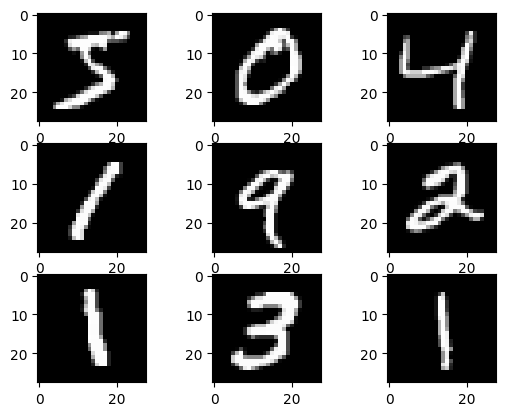

In [3]:
# define no. of subplots
num_subplots = 9

# loop through train_X
for i in range(num_subplots):
    # create subplot
    plt.subplot(330 + 1 + i)
    # display image in subplot
    plt.imshow(train_X[i], cmap=plt.cm.gray)

# show subplot
plt.show()

## Read Data

In [4]:
# load data
mnist = fetch_openml(name='mnist_784')

In [5]:
# We will use mainly two keys, data(X) and target(y)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
# This is our label.
mnist['target']

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [7]:
# assigning independent and dependent variables
X, y = mnist['data'], mnist['target']
X[:1].shape, X[:1].ndim

((1, 784), 2)

In [8]:
# observe shape and labels
X.shape, y.shape, y[:5] 

((70000, 784),
 (70000,),
 0    5
 1    0
 2    4
 3    1
 4    9
 Name: class, dtype: category
 Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9'])

In [9]:
# re=shape to visualise
image = np.array(X[:1]).reshape(28, 28)

## Training and Test Samples

Models are often prone to errors such as 'overfitting' and 'underfitting'. This can result in gross errors when computing the accuracy and specificity of the model.

Using a ratio of 60/20/20 for training, development and test size respectively, we inititially split our data of 70 000 items into a training set of 56 000 observations and a test set of 14 000 observations.

We then split the training set using a 0.25 ratio so that we have a training set of 44 800 observations and a development set of 11 200 observations.

The development set allows us to select parameters, tune them and then use them to choose the best model to increase accuracy. We can use the development set to train and evaluate our model to counteract potential 'overfitting' or 'underfitting' issues before we use our test data for predicitions.

The random_state parameter will be set to 42 so that we get the same train and test sets across different executions and ensure that the data split is deterministic.

In [10]:
# split into training and test set
X_train, X_test, y_train, y_test, = train_test_split(X, 
                y, test_size=0.2, random_state=0)

print ("Training data:",X_train.shape, y_train.shape)
print ("Test data:",X_test.shape, y_test.shape)

Training data: (56000, 784) (56000,)
Test data: (14000, 784) (14000,)


In [11]:
# split into training and development set
X_train, X_dev, y_train, y_dev, = train_test_split(X_train, 
                y_train, test_size=0.25, random_state=0)

print ("Training data:",X_train.shape, y_train.shape)
print ("Test data:",X_dev.shape, y_dev.shape)

Training data: (42000, 784) (42000,)
Test data: (14000, 784) (14000,)


X_dev and y_dev store the features and labels respectively, for the development set.

## Random Forest Classifier

In [12]:
# assign random state
r = 42

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state = r)

# fit training set to model
clf.fit(X_train, y_train)

print(clf)
                                       


RandomForestClassifier(random_state=42)


### Choosing a parameter to tune:

The random Forest Classifier has numerous parameters such as;

 - n_estimators: number of trees.

 - max_features

 - max_depth.

 - min_samples_split

 - min_samples_leaf

 - criteria
 
We chose the n_estimators parameter to tune as increasing the number of decision trees in the ensemble allows us to decrease the sensitivity to variance thus making it less prone to 'overfitting'.

Increasing the number of trees can affect efficiency as it increases computational time thus we must aim to find the optimal balance between the number of trees and accuracy.

In [13]:
n_estimators = range(1, 101)

best_n_estimators = 0
best_score = 0
for n in n_estimators:
  clf = RandomForestClassifier(n_estimators=n)
  clf.fit(X_dev, y_dev)
  score = clf.score(X_test, y_test)
  if score > best_score:
        best_score = score
        best_n_estimators = n

print('Best Value for n_estimator:', best_n_estimators)
  

Best Value for n_estimator: 93


The best value for n_estimators was chosen using the code above as it is the value that produces the highest accuracy within a range that does not severely impact computational time.

In [14]:
# using best value of n_estimators
clf = RandomForestClassifier(n_estimators=best_n_estimators)
clf.fit(X_train, y_train)

print(clf)

RandomForestClassifier(n_estimators=93)


In [15]:
# make predictions on test data
y_pred = clf.predict(X_test).reshape(-1,1)

#View first five predicitions
y_pred[0:5]

array([['0'],
       ['4'],
       ['1'],
       ['2'],
       ['7']], dtype=object)

## Confusion Matrix

The confusion matrix is a table that shows the number of incorrect and correct predictions made by the model. This provides useful insight into which classes the model struggled with most.

In [21]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm


array([[1371,    0,    0,    0,    2,    4,    5,    0,    4,    1],
       [   0, 1557,    7,    4,    3,    0,    3,    3,    2,    1],
       [   2,    3, 1398,    7,    8,    0,    5,   11,    8,    1],
       [   1,    3,   26, 1349,    0,   18,    2,   14,   18,    4],
       [   1,    0,    1,    0, 1306,    0,    7,    4,    3,   28],
       [   3,    5,    4,   13,    2, 1172,   15,    3,    6,    8],
       [   8,    2,    1,    0,    4,    7, 1361,    0,    4,    0],
       [   4,    5,   20,    2,    9,    0,    0, 1396,    3,   19],
       [   2,   11,    7,    6,    6,    7,    4,    0, 1306,   19],
       [   6,    1,    4,   20,   22,    8,    2,   13,   11, 1274]],
      dtype=int64)

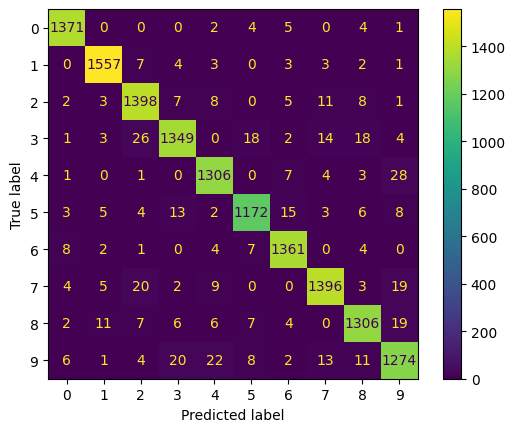

In [25]:
# Creating confusion matrix visual
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
cm_display.plot();

As we can see, the number 9 had the greatest instances of incorrect predictions, 87 in total. The largest number of a specific instance in this class was 22 where the number 9 was incorrectly classified as 4.

The number 4 had the largest number of a specific instance where it was classified as the number 9.

The number 3 had the second highest number of incorrect instances overall. The largest number of incorrect predictions for a specific instance in this class was 26 where the number 3 was incorrectly classified as the number 2.

The number 0 had the least amount of incorrect instances so was the easiest to determine. It was mostly incorrectly classified as a number 6. 

We could use this information to decide to collect more instances of these numbers to allow for better classification.

### Report accuracy, precision, recall, and f1-score

The confusion matrix provides further insight for evaluating the perfomance of the model such as accuracy, precision. recall and f1_score.

In [26]:
# accuracy
acc = accuracy_score(y_test, y_pred)

# precision
prec = precision_score(y_test, y_pred, average='weighted')

# recall
rec = recall_score(y_test, y_pred, average='weighted')

# f1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print('Accuracy: {}'.format(acc))
print('f1_score:', f1)
print('Precision:', prec)
print('Recall:', rec)

Accuracy: 0.9635714285714285
f1_score: 0.9635291758070484
Precision: 0.9635566058675782
Recall: 0.9635714285714285
